#### Explore Spark Exercises

These exercises should go in a notebook or script named `explore`. 

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [152]:
import pyspark.sql
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import wrangle

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()

plt.rc('figure', figsize = (13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size = 12)

In [6]:
df = wrangle.wrangle_311(spark)
df.show(1, vertical = True, truncate = False)

[wrangle.py] reading case.csv


[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features


[wrangle.py] joining departments
-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207        

- How many different cases are there, by department?
    - Solid Waste has 56 different cases
    - Animal Care Services has 14 different cases
    - Trans & Cap Improvements has 81 different cases
    - Parks & Recreation has 44 different cases
    - Customer Service has 2 different cases
    - Metro Health has 14 different cases
    - City Council has 2 different cases
    - DSD/Code Enforcement has 122 different cases

In [59]:
(df.groupBy('department')
 # countDistinct counts each unique case rather than all cases
 .agg(countDistinct('service_request_type')
 .alias('distinct number of cases')).show(truncate = False))

+------------------------+------------------------+
|department              |distinct number of cases|
+------------------------+------------------------+
|Solid Waste             |56                      |
|Animal Care Services    |14                      |
|Trans & Cap Improvements|81                      |
|Parks & Recreation      |44                      |
|Customer Service        |2                       |
|Metro Health            |14                      |
|City Council            |2                       |
|DSD/Code Enforcement    |122                     |
+------------------------+------------------------+



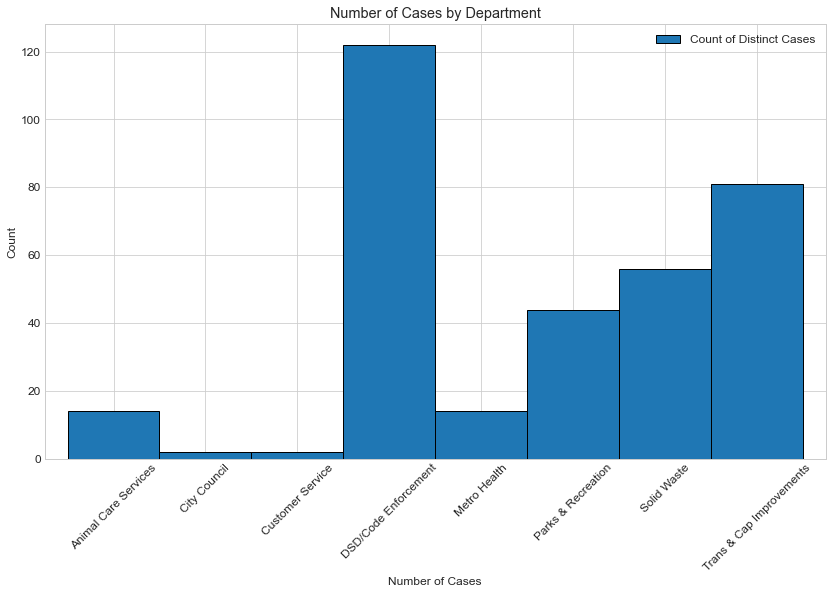

In [156]:
(df.groupBy('department')
 .agg(countDistinct('service_request_type').alias('Count of Distinct Cases'))
 .toPandas()
 .set_index('department')
 .sort_values(by = 'department')
 .plot.bar(width = 1, ec = 'black', figsize = (14, 8)))

plt.title('Number of Cases by Department')
plt.ylabel('Count')
plt.xlabel('Number of Cases')
plt.xticks(rotation = 45);

- Does the percentage of cases that are late vary by department?
    - Yes, the percentages of cases that are late range from .88% to 34.86%

In [168]:
(df.groupBy('department', 'case_late')
 .count()
 .filter(df.case_late == 'true')
 .withColumn('percentage of cases that are late', 
             concat(round(col('count') / df.filter(df.case_late == 'true')
             .count() * 100, 2), 
             lit(' %')))
 .show(truncate = False))

+------------------------+---------+-----+---------------------------------+
|department              |case_late|count|percentage of cases that are late|
+------------------------+---------+-----+---------------------------------+
|Customer Service        |true     |2010 |2.13 %                           |
|Trans & Cap Improvements|true     |5411 |5.73 %                           |
|Metro Health            |true     |829  |0.88 %                           |
|Animal Care Services    |true     |23276|24.63 %                          |
|Parks & Recreation      |true     |3797 |4.02 %                           |
|Solid Waste             |true     |32945|34.86 %                          |
|DSD/Code Enforcement    |true     |26235|27.76 %                          |
+------------------------+---------+-----+---------------------------------+



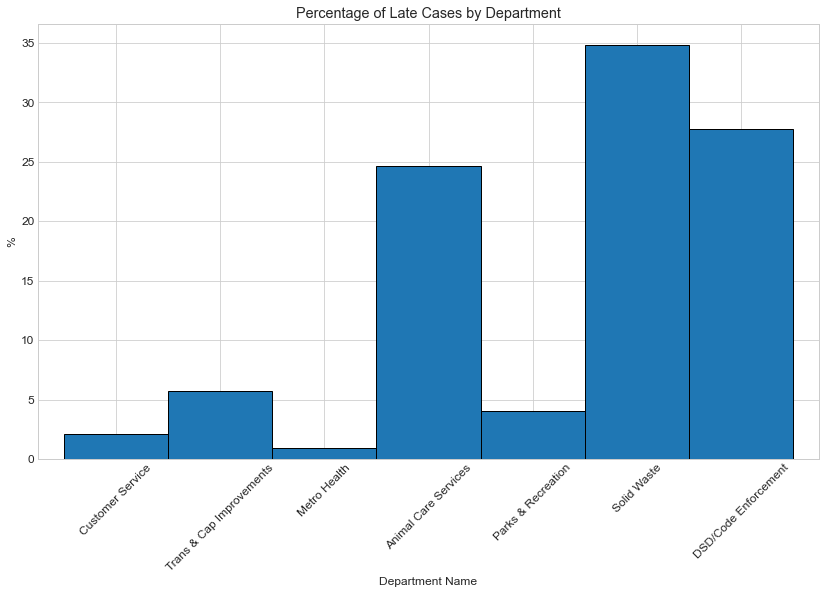

In [157]:
(df.groupBy('department', 'case_late')
 .count()
 .filter(df.case_late == 'true')
 .withColumn('percentage of cases that are late', 
             round(col('count') / df.filter(df.case_late == 'true')
             .count() * 100, 2), 
             )
 .toPandas()['percentage of cases that are late']
 .plot.bar(width = 1, ec = 'black', figsize = (14, 8))
) 


plt.title('Percentage of Late Cases by Department')
plt.ylabel('%')
plt.xlabel('Department Name')
plt.xticks(rotation = 45, ticks = np.arange(7), labels = ['Customer Service', 
                                                          'Trans & Cap Improvements',
                                                          'Metro Health',
                                                          'Animal Care Services',
                                                          'Parks & Recreation',
                                                          'Solid Waste', 
                                                          'DSD/Code Enforcement']);

- On average, how late are the late cases by department?

In [173]:
(df.groupBy('department', 'case_late')
 .agg(round(avg('num_days_late'), 2).alias('avg_days_late'))
 .filter(df.case_late == 'true').show(truncate = False)
)

+------------------------+---------+-------------+
|department              |case_late|avg days late|
+------------------------+---------+-------------+
|Customer Service        |true     |87.68        |
|Trans & Cap Improvements|true     |10.6         |
|Metro Health            |true     |6.54         |
|Animal Care Services    |true     |23.46        |
|Parks & Recreation      |true     |22.35        |
|Solid Waste             |true     |7.19         |
|DSD/Code Enforcement    |true     |49.38        |
+------------------------+---------+-------------+



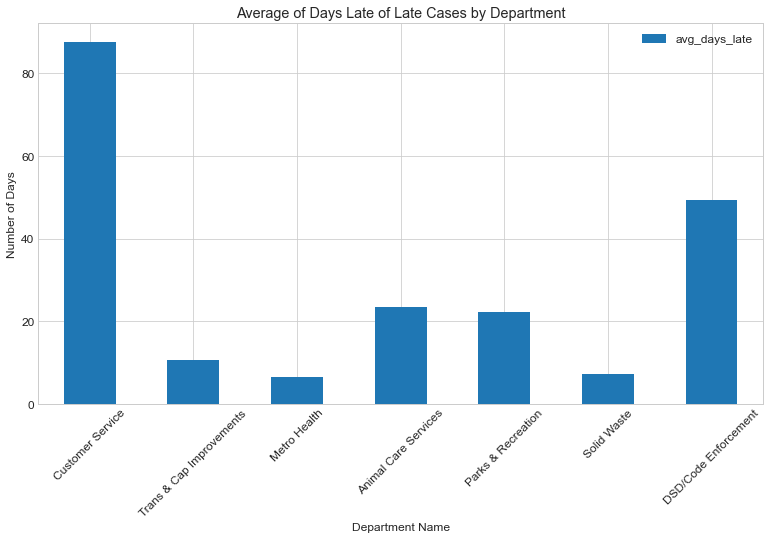

In [179]:
(df.groupBy('department', 'case_late')
 .agg(round(avg('num_days_late'), 2).alias('avg_days_late'))
 .filter(df.case_late == 'true')
 .toPandas()
 .plot.bar()
)

plt.title('Average of Days Late of Late Cases by Department')
plt.ylabel('Number of Days')
plt.xlabel('Department Name')
plt.xticks(rotation = 45, ticks = np.arange(7), labels = ['Customer Service', 
                                                          'Trans & Cap Improvements',
                                                          'Metro Health',
                                                          'Animal Care Services',
                                                          'Parks & Recreation',
                                                          'Solid Waste', 
                                                          'DSD/Code Enforcement']);

- What is the service type that is the most late? Just for Parks & Rec?
    - Overall: Trapped/Confined Animal with 5696 cases
    - For Parks & Red: Carpentry with 587 cases

In [221]:
(df.groupBy('service_request_type', 'case_late')
 .agg(count('num_days_late').alias('Count of Late Cases'))
 .filter(df.case_late == 'true')
).toPandas().sort_values(by = 'Count of Late Cases').tail(1)

,service_request_type,case_late,Count of Late Cases
31,Trapped/Confined Animal,True,5696


In [225]:
(df.groupBy('department', 'service_request_type', 'case_late')
 .agg(count('num_days_late').alias('Count of Late Cases'))
 .filter(df.department == 'Parks & Recreation')
 .filter(df.case_late == 'true')
).toPandas().sort_values(by = 'Count of Late Cases').tail(1)

,department,service_request_type,case_late,Count of Late Cases
17,Parks & Recreation,Carpentry,True,587


- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

- Does whether or not its a weekend matter for when a case is opened/closed?

- On average, how many cases are opened a day for the Customer Service department?

- Does the number of service requests for the solid waste department vary by day of the week?